In [32]:
import pandas as pd
%matplotlib inline
import seaborn as sns

### Import data

In [95]:
mta_df = pd.read_pickle('mta_2018')

### Clean columns

In [96]:
# reset mta data index
mta_df.reset_index(drop=True,inplace=True)

# rename column EXITS
mta_df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)

In [97]:
# Combine DATE, TIME to DateTime
mta_df['DateTime'] = pd.to_datetime(mta_df['DATE'] + " " + mta_df['TIME'])
# Create day_of_week column
mta_df['day_of_week'] = mta_df.DateTime.apply(lambda x: x.weekday())

In [98]:
# Create Unique Daily ID for each turnstile
mta_df['UNIQUEID'] = mta_df['STATION'] + '_' + mta_df['UNIT'] + '_' + mta_df['C/A'] \
+ '_' + mta_df['SCP']

In [99]:
# Find time_span (hr) between each row
# Note that most are 4.0 hrs but some are not
mta_df['time_span (hr)'] = mta_df.DateTime.diff().apply(lambda x: x.total_seconds()/3600)

### Find entries for each row

In [100]:
# clean ENTRIES/EXITS as they are cumulative data
mta_df['entries'] = mta_df.ENTRIES.diff()
mta_df['exits'] = mta_df.EXITS.diff()

In [101]:
# Find avg_entries (entries per hour)
mta_df['avg_entries'] = mta_df['entries']/ mta_df['time_span (hr)']

# Find median_hour (center of the time slot)
# Corresponds to 2am, 6am, 10am, 14=2pm,...
mta_df['median_hour'] = (mta_df['DateTime'] \
                              - (pd.Timedelta(seconds=penn_filter.iloc[1]['time_span (hr)']*3600)/2)).dt.hour

In [102]:
# Drop unnecessary columns
mta_df.drop(columns=['DATE','TIME','C/A','UNIT','SCP','LINENAME','DESC','ENTRIES','EXITS'],inplace=True)

In [135]:
mta_df.head()

,STATION,DIVISION,DateTime,day_of_week,UNIQUEID,time_span (hr),entries,exits,avg_entries,median_hour
0,59 ST,BMT,2018-05-12 00:00:00,5,59 ST_R051_A002_02-00-00,NaN,NaN,NaN,NaN,22
1,59 ST,BMT,2018-05-12 04:00:00,5,59 ST_R051_A002_02-00-00,4.0,19.0,5.0,4.75,2
2,59 ST,BMT,2018-05-12 08:00:00,5,59 ST_R051_A002_02-00-00,4.0,19.0,31.0,4.75,6
3,59 ST,BMT,2018-05-12 12:00:00,5,59 ST_R051_A002_02-00-00,4.0,105.0,85.0,26.25,10
4,59 ST,BMT,2018-05-12 16:00:00,5,59 ST_R051_A002_02-00-00,4.0,219.0,49.0,54.75,14


### Choose station

In [104]:
# Choose penn station data
penn_df = mta_df[mta_2018_df.STATION == '34 ST-PENN STA'].iloc[1:]

# Filter for entries between 0 and 3000
# Outliers come from switching to next turnstiles (should be the same as dropping first rows of each turnstile)
# Filter out the negative values of avg_entries
# (should be the same as dropping first value of each turnstile on a new day)
penn_filter = penn_df[(penn_df.entries<100000) & (penn_df.entries>0)].copy()

Check if the value of entries make sense:

In [105]:
penn_filter.entries.min(),penn_filter.entries.mean(),penn_filter.entries.max()

(1.0, 261.16173425078495, 2812.0)

In [107]:
# Check if values of avg_entries make sense
# Found negative values: happens when switching to next turnsiles
penn_filter['avg_entries'].min(), penn_filter['avg_entries'].mean(), penn_filter['avg_entries'].max()

(0.25, 65.73918678104937, 703.0)

In [109]:
# There are 95 turnstiles in Penn station?
penn_filter.UNIQUEID.nunique()

95

In [110]:
penn_filter.avg_entries.min(),penn_filter.avg_entries.mean(),penn_filter.avg_entries.max()

(0.25, 65.73918678104937, 703.0)

In [137]:
penn_filter.sort_values('avg_entries',ascending=False)

,STATION,DIVISION,DateTime,day_of_week,UNIQUEID,time_span (hr),entries,exits,avg_entries,median_hour
129862,34 ST-PENN STA,IRT,2018-05-16 10:00:00,2,34 ST-PENN STA_R293_R138_00-00-03,4.0,2812.0,71.0,703.00,8
129868,34 ST-PENN STA,IRT,2018-05-17 10:00:00,3,34 ST-PENN STA_R293_R138_00-00-03,4.0,2683.0,74.0,670.75,8
721383,34 ST-PENN STA,IRT,2018-06-04 10:00:00,0,34 ST-PENN STA_R293_R138_00-00-03,4.0,2642.0,106.0,660.50,8
721299,34 ST-PENN STA,IRT,2018-06-04 10:00:00,0,34 ST-PENN STA_R293_R138_00-00-01,4.0,2602.0,143.0,650.50,8
721389,34 ST-PENN STA,IRT,2018-06-05 10:00:00,1,34 ST-PENN STA_R293_R138_00-00-03,4.0,2596.0,79.0,649.00,8
...,...,...,...,...,...,...,...,...,...,...
643681,34 ST-PENN STA,IND,2018-06-02 04:00:00,5,34 ST-PENN STA_R013_N073_02-00-00,4.0,1.0,8.0,0.25,2
50850,34 ST-PENN STA,IND,2018-05-13 12:00:00,6,34 ST-PENN STA_R012_N067_00-06-00,4.0,1.0,0.0,0.25,10
642283,34 ST-PENN STA,IND,2018-06-07 08:00:00,3,34 ST-PENN STA_R012_N067_00-06-00,4.0,1.0,0.0,0.25,6
445891,34 ST-PENN STA,IND,2018-05-27 08:00:00,6,34 ST-PENN STA_R013_N069_01-06-00,4.0,1.0,19.0,0.25,6


In [138]:
# Sum over all turnstiles
penn_total = penn_filter.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
# penn_total

In [139]:
penn_total.avg_entries.sum()/28

35144.63881876886

In [140]:
# Compare group station and sum
penn_total_test = penn_filter.groupby(["STATION"])['avg_entries'].sum().reset_index()
penn_total_test.avg_entries.sum()/28

35144.63881876886

In [141]:
# Average over day
penn_total_byday = penn_total.groupby("median_hour")['avg_entries'].mean().reset_index()
penn_total_byday

,median_hour,avg_entries
0,0,2383.458333
1,2,1873.781752
2,4,750.340358
3,6,12370.829455
4,8,16430.964286
5,10,26360.821429
6,12,7899.571429
7,14,18185.452239
8,15,1803.601191
9,16,9497.589689


Text(0, 0.5, 'total entries')

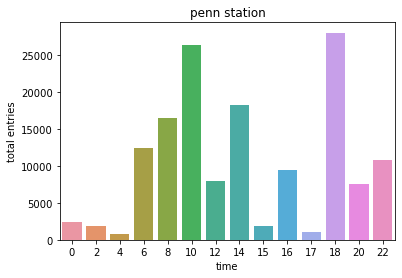

In [142]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_total_byday)
ax.set_title('penn station')
ax.set_xlabel('time')
ax.set_ylabel('total entries')

Text(0, 0.5, 'total entries')

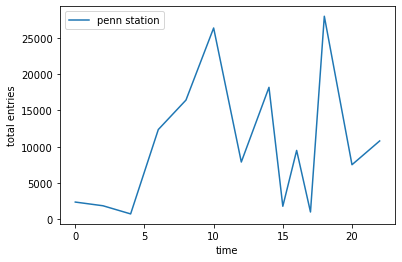

In [143]:
# Same data shown in lineplot (can overlap with data from other stations)
ax = sns.lineplot(x='median_hour', y= 'avg_entries', data = penn_total_byday, label='penn station')
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('total entries')

In [144]:
# Day of week daily entries
# Sum over all turnstiles
# penn_total = penn_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()

# Sum over hours for one day
penn_total_byweek = penn_total.groupby("day_of_week")['avg_entries'].sum().reset_index()
penn_total_byweek

,day_of_week,avg_entries
0,0,146550.250000
1,1,173282.875000
2,2,176522.525960
3,3,178489.624715
4,4,165299.678492
5,5,68288.875000
6,6,75616.057758


Text(0, 0.5, 'total entries')

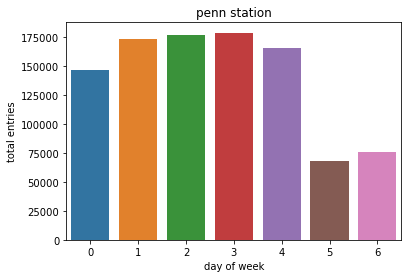

In [145]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='day_of_week', y= 'avg_entries', data = penn_total_byweek)
ax.set_title('penn station')
ax.set_xlabel('day of week')
ax.set_ylabel('total entries')

In [146]:
# Check the daily entries
penn_total_byday.avg_entries.mean(),penn_total_byday.avg_entries.mean()*24

(10348.432876164139, 248362.38902793935)

In [147]:
# weekday/weekend
penn_weekday = penn_filter[penn_filter['day_of_week'] < 5]
penn_weekend = penn_filter[penn_filter['day_of_week'] >= 5]

In [148]:
penn_weekend

,STATION,DIVISION,DateTime,day_of_week,UNIQUEID,time_span (hr),entries,exits,avg_entries,median_hour
50309,34 ST-PENN STA,IND,2018-05-12 04:00:00,5,34 ST-PENN STA_R012_N067_00-00-00,4.0,6.0,6.0,1.50,2
50310,34 ST-PENN STA,IND,2018-05-12 08:00:00,5,34 ST-PENN STA_R012_N067_00-00-00,4.0,28.0,43.0,7.00,6
50311,34 ST-PENN STA,IND,2018-05-12 12:00:00,5,34 ST-PENN STA_R012_N067_00-00-00,4.0,95.0,116.0,23.75,10
50312,34 ST-PENN STA,IND,2018-05-12 16:00:00,5,34 ST-PENN STA_R012_N067_00-00-00,4.0,150.0,150.0,37.50,14
50313,34 ST-PENN STA,IND,2018-05-12 20:00:00,5,34 ST-PENN STA_R012_N067_00-00-00,4.0,105.0,157.0,26.25,18
...,...,...,...,...,...,...,...,...,...,...
722593,34 ST-PENN STA,IRT,2018-06-03 06:00:00,6,34 ST-PENN STA_R293_R142_01-06-01,4.0,9.0,7.0,2.25,4
722594,34 ST-PENN STA,IRT,2018-06-03 10:00:00,6,34 ST-PENN STA_R293_R142_01-06-01,4.0,46.0,67.0,11.50,8
722595,34 ST-PENN STA,IRT,2018-06-03 14:00:00,6,34 ST-PENN STA_R293_R142_01-06-01,4.0,120.0,173.0,30.00,12
722596,34 ST-PENN STA,IRT,2018-06-03 18:00:00,6,34 ST-PENN STA_R293_R142_01-06-01,4.0,115.0,271.0,28.75,16


In [149]:
# Weekday data
# Sum over all turnstiles
penn_weekday_total = penn_weekday.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
# Average over day
penn_weekday_total_byday = penn_weekday_total.groupby("median_hour")['avg_entries'].mean().reset_index()
# penn_weekday_total_byday

Text(0, 0.5, 'total entries')

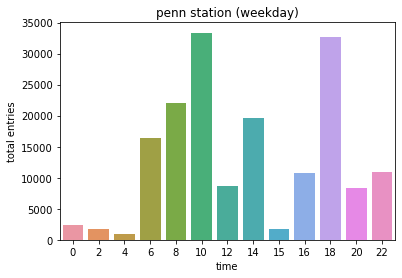

In [150]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_weekday_total_byday)
ax.set_title('penn station (weekday)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')

In [151]:
# Weekend data
# Sum over all turnstiles
penn_weekend_total = penn_weekend.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()
# Average over day
penn_weekend_total_byday = penn_weekend_total.groupby("median_hour")['avg_entries'].mean().reset_index()
# penn_weekend_total_byday

Text(0, 0.5, 'total entries')

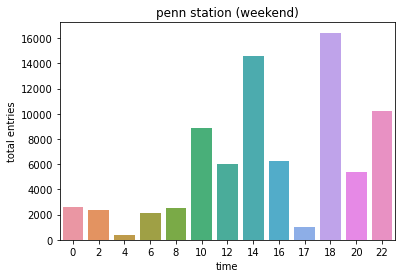

In [152]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='median_hour', y= 'avg_entries', data = penn_weekend_total_byday)
ax.set_title('penn station (weekend)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')

Text(0, 0.5, 'total entries')

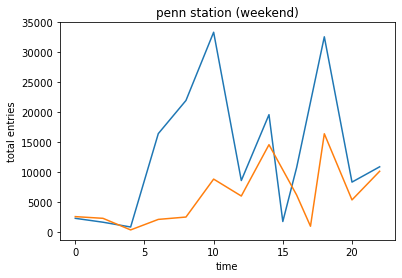

In [134]:
# Plot together for comparison
ax = sns.lineplot(x='median_hour', y= 'avg_entries', data = penn_weekday_total_byday)
ax.set_title('penn station (weekday)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')
ax = sns.lineplot(x='median_hour', y= 'avg_entries', data = penn_weekend_total_byday)
ax.set_title('penn station (weekend)')
ax.set_xlabel('time')
ax.set_ylabel('total entries')